# Day 08. Exercise 03
# Overfitting

## 0. Imports

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [112]:
def draw_barh_plot(coefs, features_names, top_n: int = 5):
    vals = dict(sorted(zip(features_names, coefs), key=lambda x: x[1])[-top_n:])
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.barh(list(vals.keys()), list(vals.values()), color='c')

## 1. Preprocessing

1. Read the file `dayofweek.csv` to a dataframe.
2. Using `train_test_split` with parameters `test_size=0.2`, `random_state=21` get `X_train`, `y_train`, `X_test`, `y_test`.
3. Using, for example, `value_counts()` to check if the distribution of classes is similar in train and test.
4. Use the additional parameter `stratify=` and check the distribution again, now it should be more or less similar in both datasets.

In [58]:
df = pd.read_csv('../data/dayofweek.csv')
df.head()

,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,uid_user_16,uid_user_17,...,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1,numTrials,hour,dayofweek
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.788667,-2.562352,4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.756764,-2.562352,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.724861,-2.562352,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.692958,-2.562352,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.661055,-2.562352,4


In [59]:
X = df.loc[:, df.columns != 'dayofweek']
y = df.dayofweek

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [61]:
## To check if the distribution of classes is similar in train and test.

# for val in X_train.value_counts().values:
#     print(val, end=',')
# print('\n', X_train.columns.values)

# for val in X_test.value_counts().values:
#     print(val, end=',')
# print('\n', X_test.columns.values)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

## 2. Baseline models

1. Train exactly the same baseline models from the previous exercise and calculate the accuracies using the test dataset with stratification.
2. Did all the models show the similar values of the metric? Which one has the largest difference comparing the current exercise and the previous? Put the answer to the markdown cell in the end of the section.

### a. Logreg

In [63]:
clf_logreg = LogisticRegression(random_state=21, fit_intercept=False).fit(X_train, y_train)
logreg_score = clf_logreg.score(X_test, y_test)
logreg_score

0.6272189349112426

### b. SVM

In [64]:
clf_svc = SVC(kernel='linear', probability=True, random_state=21).fit(X_train, y_train)
svc_score = clf_svc.score(X_test, y_test)
svc_score

0.7159763313609467

### c. Decision tree

In [65]:
tree = DecisionTreeClassifier(max_depth=4, random_state=21).fit(X_train, y_train)
tree_score = tree.score(X_test, y_test)
tree_score

0.5295857988165681

### d. Random forest

In [66]:
forest = RandomForestClassifier(n_estimators=50, max_depth=25, random_state=21).fit(X_train, y_train)
# forest = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21).fit(X_train, y_train)
forest_score = forest.score(X_test, y_test)
forest_score

0.9289940828402367

---
### Comparing accuracy scores

In [67]:
pd.DataFrame({'logreg': [0.6405693950177936, logreg_score],
              'SVM': [0.702846975088968, svc_score],
              'Decision tree': [0.5516014234875445, tree_score],
              'Random forest': [0.9988137603795967, forest_score]
             }, index=['Before', 'After'])

,logreg,SVM,Decision tree,Random forest
Before,0.640569,0.702847,0.551601,0.998814
After,0.627219,0.715976,0.529586,0.928994


> `Random forest` has the largest diffence in accuracy score

## 3. Crossvalidation

We could play with parameters of the model trying to achive a better accuracy on the test dataset, but it is a bad practice. It leads us again to overfitting. Test dataset is only for checking quality of a final model.

But there is another way of solving the problem – crossvalidation. It does not use test dataset, but creates one more split of train dataset. Again, there are different ways of doing it, but the common thing is that there is a validation dataset that is used for hyperparameters optimization.

1. Using `cross_val_score` with `cv=10` calculate the mean accuracy and standard deviation for every model that you used before (logreg with `solver='liblinear'`, SVC, decision tree, random forest).

### a. Logreg

In [79]:
clf_logreg = LogisticRegression(solver='liblinear', random_state=21, fit_intercept=False)
logreg_score = cross_val_score(clf_logreg, X, y, cv=10)
print('Mean value:', logreg_score.mean())
print('Standard deviation:', logreg_score.std())

Mean value: 0.45291983657368284
Standard deviation: 0.16960708432126997


### b. SVM

In [78]:
clf_svc = SVC(kernel='linear', probability=True, random_state=21)
svc_score = cross_val_score(clf_svc, X, y, cv=10)
print('Mean value:', svc_score.mean())
print('Standard deviation:', svc_score.std())

Mean value: 0.5051986475063398
Standard deviation: 0.15857963555262297


### c. Decision tree

In [80]:
tree = DecisionTreeClassifier(max_depth=4, random_state=21)
tree_score = cross_val_score(tree, X, y, cv=10)
print('Mean value:', tree_score.mean())
print('Standard deviation:', tree_score.std())

Mean value: 0.3883523527754297
Standard deviation: 0.11835394295385691


### d. Random forest

In [81]:
forest = RandomForestClassifier(n_estimators=50, max_depth=25, random_state=21)
forest_score = cross_val_score(forest, X, y, cv=10)
print('Mean value:', forest_score.mean())
print('Standard deviation:', forest_score.std())

Mean value: 0.6441849816849816
Standard deviation: 0.18105336158110988


> `Random forest` has the best accuracy scores

## 4. Optimization

1. Choose the best model and play a little bit with the parameters on cross-validation, find a good enough parameter or a combination of the parameters.
2. Calculate the accuracy for the final model on the test dataset.
3. Draw a plot that displays the top-10 most  important features for that model.
4. Save the model using `joblib`.
5. Load the model, make predictions for the test dataset and calculate the accuracy.

Cross validation using `cross_val_score`:
- Increasing `n_estimators` more than ***100*** gives nothing
- Increasing `max_depth` gives nothing

In [99]:
forest = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
forest_score = cross_val_score(forest, X, y, cv=10)
print('Mean value:', forest_score.mean())
print('Standard deviation:', forest_score.std())

Mean value: 0.6560545224006762
Standard deviation: 0.18253763161728986


Cross validation using `splitting`:
- Increasing `n_estimators` more than ***100*** gives nothing
- Increasing `max_depth` gives nothing

In [111]:
forest = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21).fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.9319526627218935

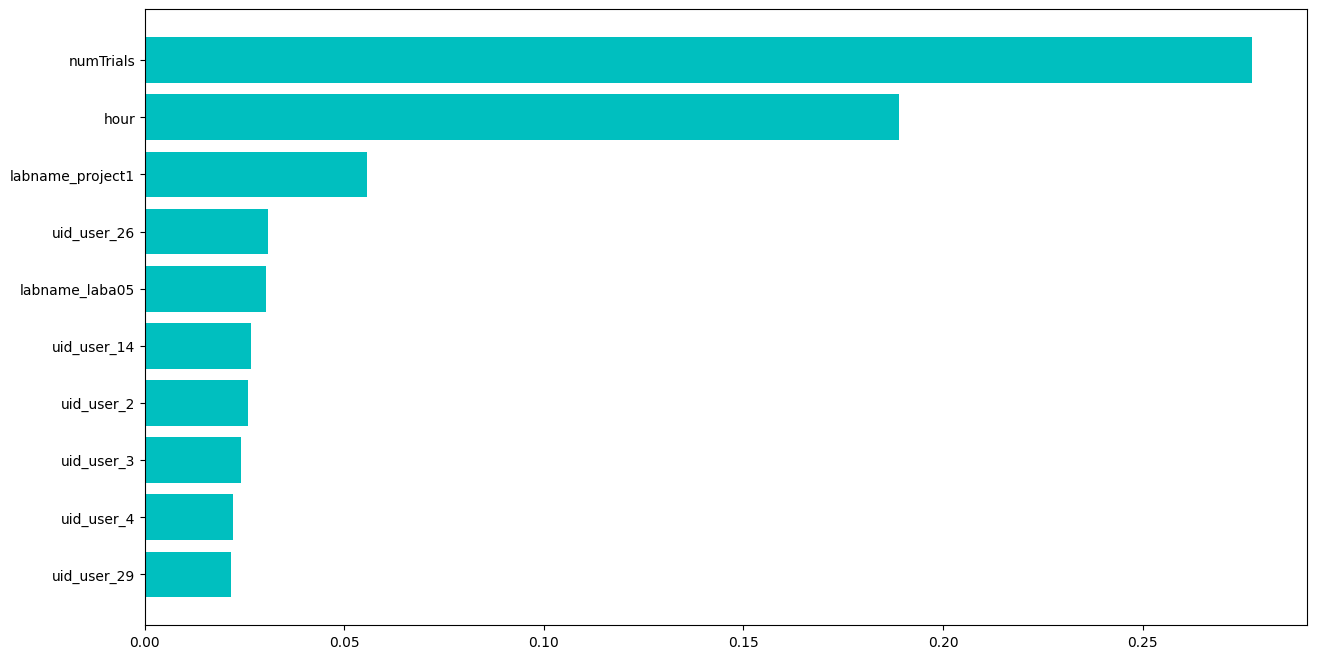

In [113]:
draw_barh_plot(abs(forest.feature_importances_), forest.feature_names_in_, 10)